## Monte Carlo Policy Gradient (REINFORCE)
![](./image/REINFORCE.png)

最重要的公式是：
$$\theta \leftarrow \theta + \alpha \nabla_{\theta}\log \pi_{\theta} (s_t, a_t)v_t$$

这个公式的来源就是一个非常著名的工作：__策略梯度定理__

对于离散环境或者是连续环境来说，__累积奖励和__可以定义成:
$$J(\theta)=\mathbb{E}_{\pi_{\theta}}[r]=\sum_{s\in S}d(s)\sum_{a\in A}\pi_{\theta}(s,a)Q(s,a)$$
其中的 $d(s)$ 是状态的初始化概率分布

---

策略梯度的方法是 Policy-based 的RL方法，直接对策略 $\pi$ 使用梯度下降优化(目的是通过优化策略从而最大化累积奖励)，__策略梯度__为：
$$\nabla_{\theta}J(\theta)=\mathbb{E}_{\pi_{\theta}}[\nabla_{\theta}\log \pi_{\theta}(s,a)Q^{\pi_{\theta}}(s,a)]$$

* $\nabla_{\theta}\log \pi_{\theta}(s,a)$ 是在状态 $s$ 下执行动作 $a$ 得到的修正的梯度
* $r$ 表示奖励的好坏，奖励很大，修正的力度很大
* 一般训练中，使用最小化 $-J(\theta)$ 实现奖励和 $J(\theta)$ 最大化 

---

因为是 Monte Carlo 模拟方法，需要等到一个 episode 结束才可以执行优化

In [1]:
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output
from brain.MTPG import PolicyGradient
from utils import *
import gym
import time
import pandas
import numpy as np
import ipdb
import pickle
from tqdm import tqdm
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
%matplotlib inline

In [2]:
env = gym.make('LunarLander-v2')
# LunarLander-v2, learning rate 0.001, epsilon 5000
env.seed(1)     # reproducible, general Policy gradient has high variance
agent = PolicyGradient(n_actions=env.action_space.n,
                       n_features=env.observation_space.shape[0],
                       learning_rate=0.001,    # 0.01 is good for CartPole-v0, 0.001 is good for LunarLnader-v2
                       reward_decay=0.99,)

In [3]:
# Faster than DQN / Dueling DQN, and performance is better
final_rewards = []
pbar = tqdm(range(5000))
for i_episode in pbar:
    observation = env.reset()
    rewards = []
    for t in range(200):
        action = agent.choose_action(observation)

        observation_, reward, done, info = env.step(action)
        rewards.append(reward)

        agent.store_transition(observation, action, reward)

        if done:
            ep_rs_sum = sum(agent.ep_rs)

            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
                
            vt = agent.learn()
            break

        observation = observation_
    pbar.set_description(f'Running rewards: {round(running_reward, 4)}, Current rewards: {round(np.sum(rewards))}')
    final_rewards.append(np.sum(rewards))

Running rewards: 188.5717, Current rewards: 28.0: 100%|██████████| 5000/5000 [13:39<00:00,  4.86it/s]


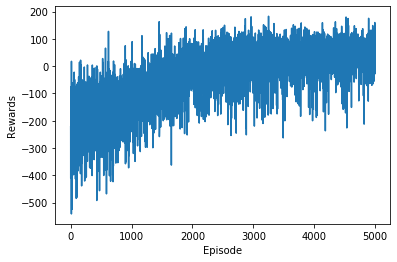

In [4]:
x = np.arange(len(final_rewards))
plt.plot(x, final_rewards)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.savefig('./image/MTPG-cartpole.png')